In [3]:
rm(list = ls())
graphics.off()
library(lhs)
#this function returns the fraction of a vector that is between a lower bound and an upper bound
frac_between <- function (vect1,vect2,vect3){ #vect2 is lower, vect3 is higher
  totlen<-length(vect1)
  out<-0
  for (i in 1:totlen){
    if ((vect1[i]<vect2[i]) | (vect1[i]>vect3[i])){
      out<-out+1
    }
  }
  return((totlen-out)/totlen)
}

In [4]:
x<-c(1:50)
#true observed data has quadratic form plus a white noise
observed<-0.05*(x-25)^2+rnorm(50,mean=0,sd=5)

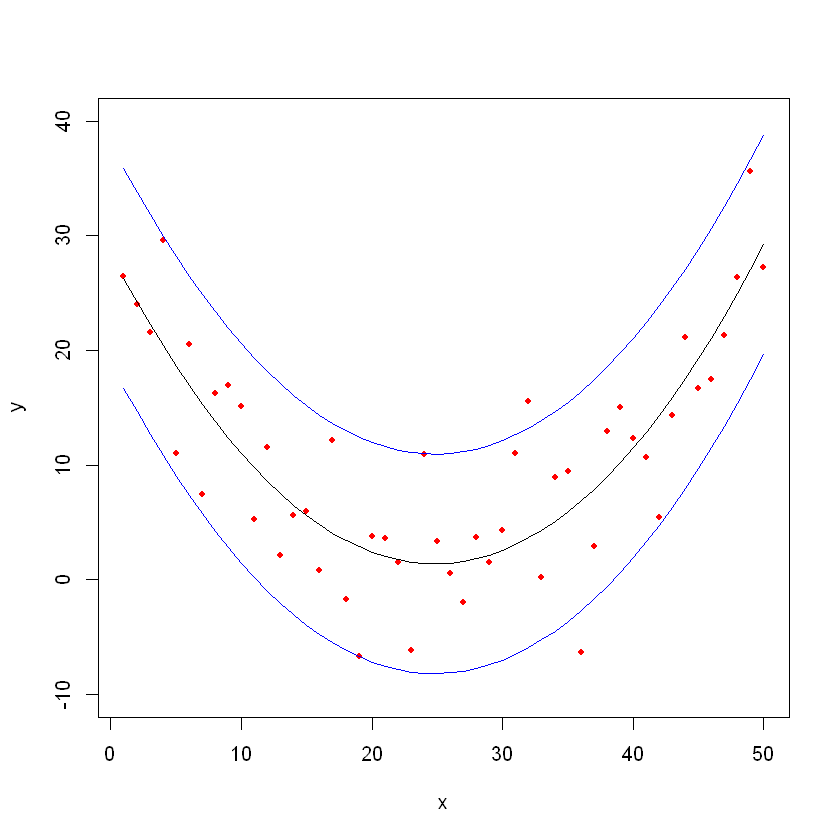

In [5]:
Data<-data.frame(observed=observed,x=x)
plot(x,observed,pch=20,xlab="x",ylab="y",ylim=c(-10,40),col="red")
#best estimate from a quadratic model regression
model<-lm(observed~poly(x,2),data = Data)
bestestimate<-predict(model,Data)
lines(x,bestestimate)
#find the boundaries that cover 95% data
for (i in 1:2000){
  step<-0.01*i
  upperbound<-bestestimate+step
  lowerbound<-bestestimate-step
  if (frac_between(observed,lowerbound,upperbound)>=0.95){
    break
  }
}
lines(x,upperbound,col="blue")
lines(x,lowerbound,col="blue")

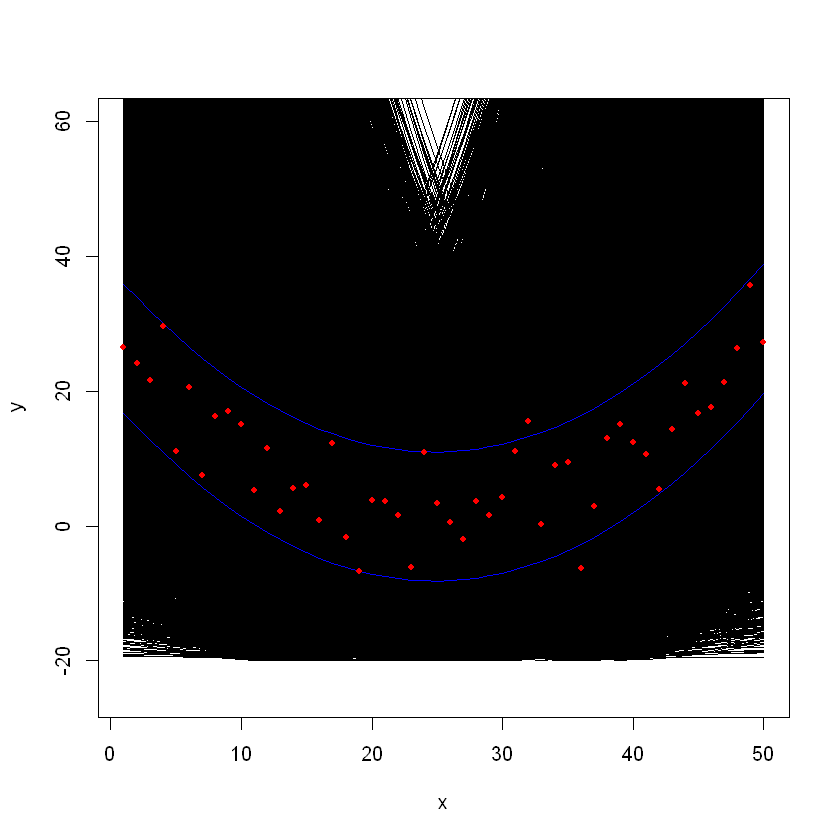

In [6]:
#wide range of three parameters
range_a<-c(0,0.2)
range_b<-c(10,40)
range_c<-c(-20,15)
plot(0,0,xlim=c(1,50),ylim=c(-25,60),xlab="x",ylab="y",type = "n")
#10000 Latin Hypercube sampling parameter samples
n<-10000
LHS<-randomLHS(n,3)
a<-rep(NA,n)
b<-rep(NA,n)
c<-rep(NA,n)
yhind<-matrix(NA,nrow=n,ncol=50)
for (i in 1:n){
  a[i]<-range_a[1]+LHS[i,1]*(range_a[2]-range_a[1])
  b[i]<-range_b[1]+LHS[i,2]*(range_b[2]-range_b[1])
  c[i]<-range_c[1]+LHS[i,3]*(range_c[2]-range_c[1])
  #plot the hindcast calculated from each parameter sample
  yhind[i, ]<-a[i]*(x-b[i])^2+c[i]
  lines(x,yhind[i, ],lwd=0.1)
}
lines(x,upperbound,col="blue")
lines(x,lowerbound,col="blue")
points(x,observed,pch=20,col="red")

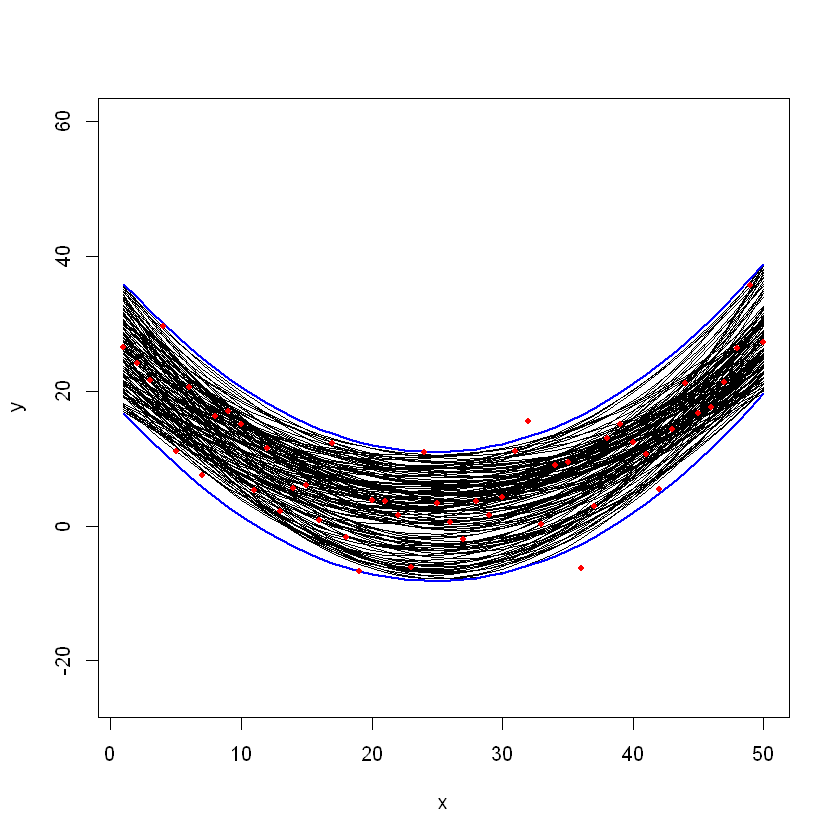

In [7]:
plot(0,0,xlim=c(1,50),ylim=c(-25,60),xlab="x",ylab="y",type = "n")
for (i in 1:n){
    #keep the samples whose hindcasts are within the boundaries
    if (frac_between(yhind[i, ],lowerbound,upperbound)==1){
        lines(x,yhind[i, ],lwd=0.1)
      }
  }
lines(x,upperbound,col="blue",lwd=2)
lines(x,lowerbound,col="blue",lwd=2)
points(x,observed,pch=20,col="red")


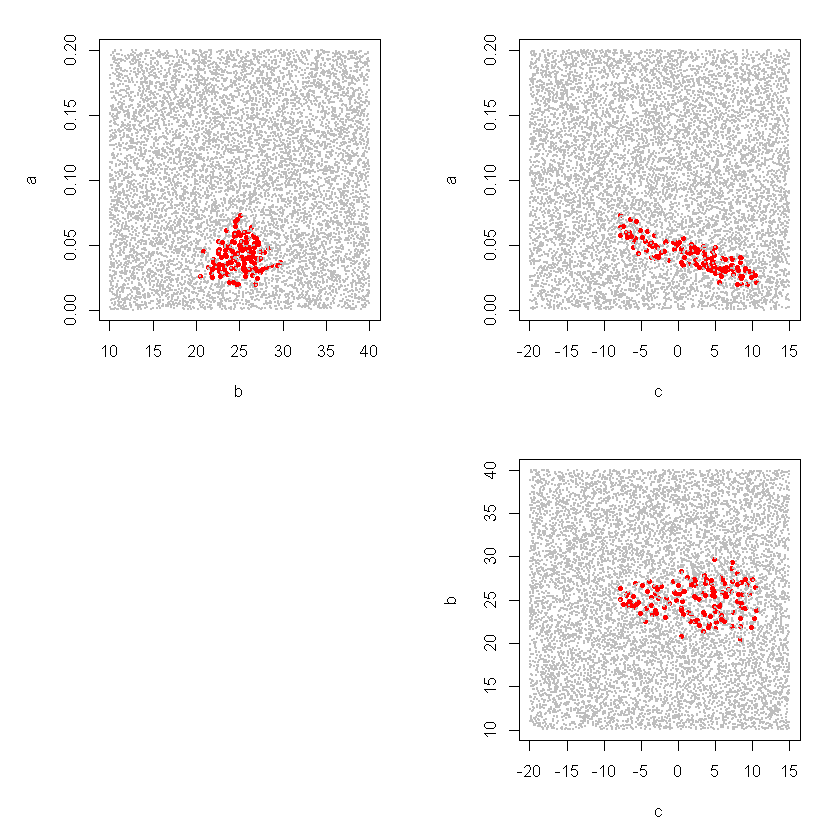

In [9]:
#scatter parameter plots, red points are the kept samples
par(mfrow=c(2,2),mar=c(5,5,2,2))
for (j in 1:2){
  for (k in 1:2){
    if ((j==1)&(k==1)){
      plot(0,0,xlim=range_b,ylim=range_a,xlab="b",ylab="a",type = "n")
      for (i in 1:n){
        if (frac_between(yhind[i, ],lowerbound,upperbound)==1){
          points(b[i],a[i],pch=20,cex=1,col="red")
        } else{
          points(b[i],a[i],pch=20,cex=0.1,col="grey")
        }
      }
    }
    if ((j==2)&(k==1)){
      plot(0,type='n',axes=FALSE,ann=FALSE)
    }
    if ((j==1)&(k==2)){
      plot(0,0,xlim=range_c,ylim=range_a,xlab="c",ylab="a",type = "n")
      for (i in 1:n){
        if (frac_between(yhind[i, ],lowerbound,upperbound)==1){
          points(c[i],a[i],pch=20,cex=1,col="red")
        } else{
          points(c[i],a[i],pch=20,cex=0.1,col="grey")
        }
      }
    }
    if ((j==2)&(k==2)){
      plot(0,0,xlim=range_c,ylim=range_b,xlab="c",ylab="b",type = "n")
      for (i in 1:n){
        if (frac_between(yhind[i, ],lowerbound,upperbound)==1){
          points(c[i],b[i],pch=20,cex=1,col="red")
        } else{
          points(c[i],b[i],pch=20,cex=0.1,col="grey")
        }
      }
    }
  }
}